In [ ]:
# default_exp contextual_bandits

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

np.random.seed(42)
%matplotlib inline

matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
plt.style.use(matplotlib_style)

from sklearn.utils import shuffle
import random
from fastprogress.fastprogress import master_bar, progress_bar

plt.rcParams['figure.figsize'] = 16,5

%load_ext autoreload
%autoreload 2

In [ ]:
from thompson_sampling.helpers import plot_regret, showcase_code
from thompson_sampling.multi_armed_bandits import contextual_categorical_bandit, contextual_categorical_get_optimal_arm
from thompson_sampling.solvers import BetaBandit, LogisticThompsonSampler
from thompson_sampling.models import OnlineLogisticRegression


In [ ]:
theta = [1.9, 0.3]
noise = 0.1

presentation = True

In the presentation on non-contextual multi armed bandits we learend how we can select the optimal choice from a  number of arms, such as colors for buttons; or colors for pills to lure in the chosen one. 

In this Notebook however, we will learn that often 'point black' optimization does not lead to acceptable results and that we can do a lot better.

Let's remember: in the noncontextual case, we first defined an agent ( e.g. a customer) and tested different algorithms against it, to see how well our choice influences the behaviour of our agent with regards to some outcome that we want to optimize. 

Contrary to last time, we won't look at the agent in detail just yet. Instead, we are going to try and use the betaBandit we used last time, assuming that our approach is still valuable. 

Let's first look at the customer's average response. The new agent takes a new parameter, <context>. Since we're not sure what that is, we'll set it to 1. 1 is a fantastic number. Why not use 1. Oh look, a squirrel!

In [ ]:
np.mean([contextual_categorical_bandit(context = np.array(1), choice = 0, theta=theta,noise=noise)[0] for x in range(100)])

0.88

In [ ]:
np.mean([contextual_categorical_bandit(context = np.array(1), choice = 1, theta=theta,noise=noise)[0] for x in range(100)])

0.61

It looks like our agent's react quite differently to different choices when evaluated at this - very mysterious - 1. It looks like our BetaBandit should be able to detect the optimal arm rather quickly and then we can go back to petting dogs and don't have to worry about any of this nonsense any more.
Since the agent needs context, we'll give him some - just a shuffled vector tho, nothing fancy. 

In [ ]:
num_data = 1500
X_original = np.linspace(-6, 6, num_data)
X = shuffle(X_original)

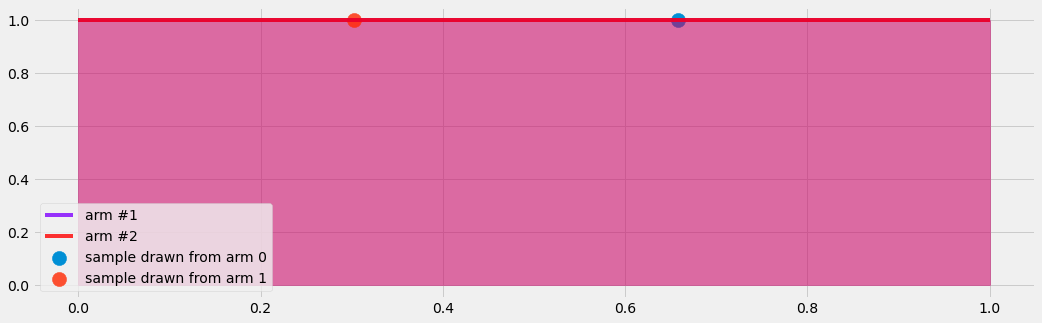

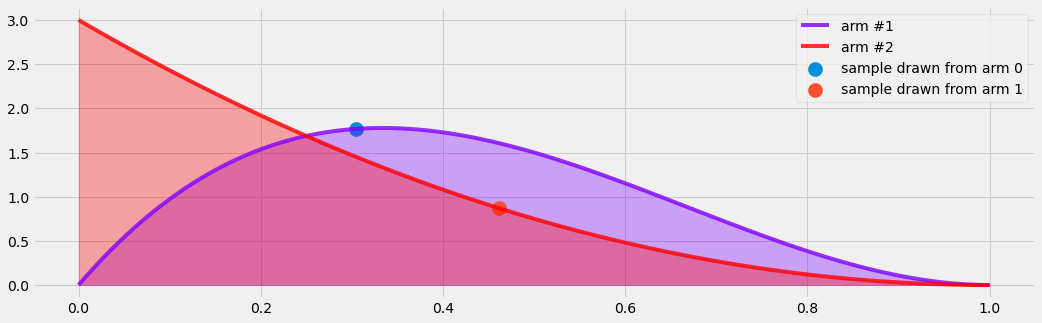

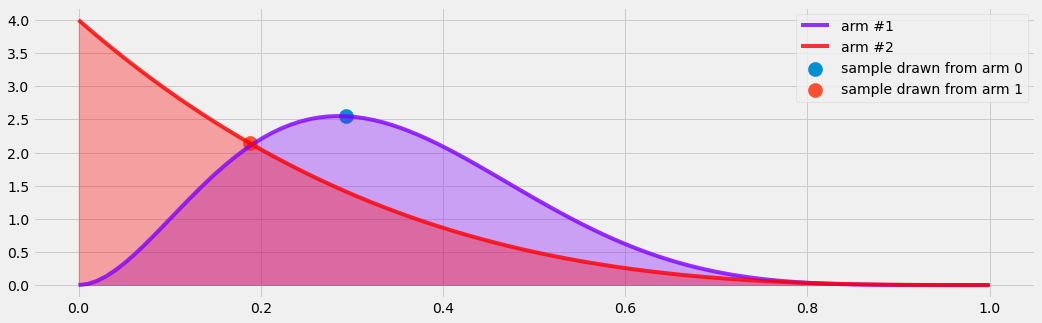

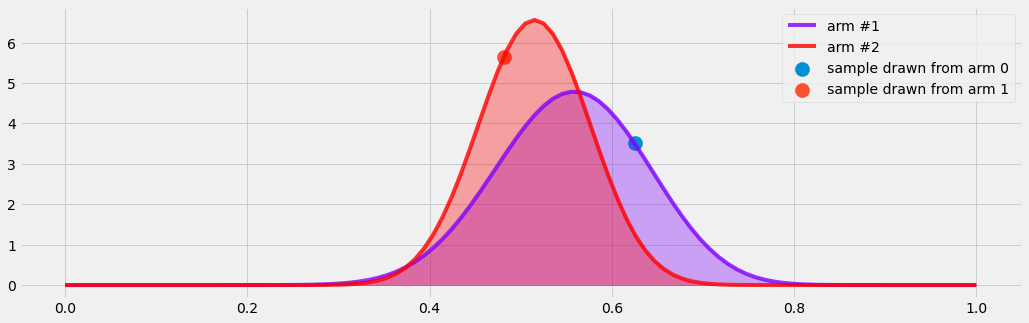

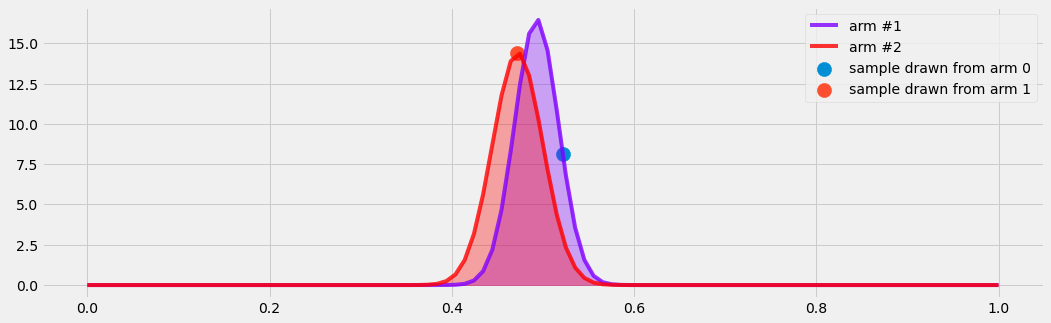

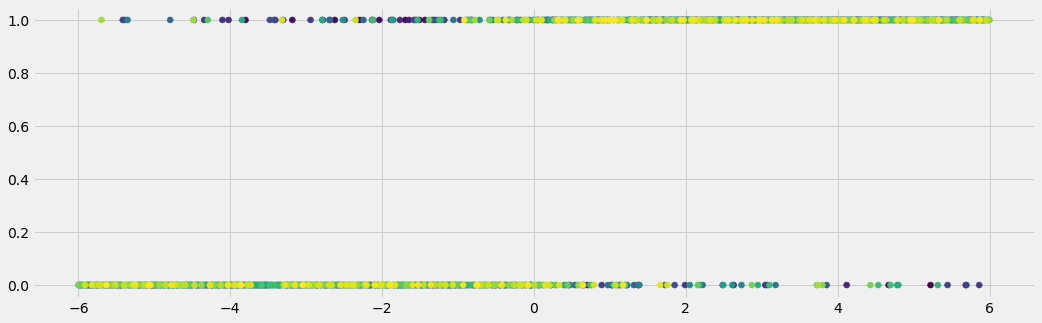

In [ ]:
bb = BetaBandit()

y_hat_list = []
y_optimal_list = []

for i in progress_bar(range(num_data)):
    
    
    context = X[i]
    if i  in [0,5,10, 100, num_data//2, num_data]:
        plt.figure()
        arm = bb.choose_arm_and_plot()
        plt.show()
        
        # when presenting, give some time to ingest the last image before going on
        if presentation:
            time.sleep(1)
    else:
        arm = bb.choose_arm()
    y_hat = contextual_categorical_bandit(context,arm, theta,noise)[0]
    y_hat_list += [y_hat]
    bb.update(arm, y_hat)
    y_optimal = contextual_categorical_bandit(context, contextual_categorical_get_optimal_arm(context), theta, noise)[0]
    y_optimal_list.append(y_optimal)


plt.figure()
plt.scatter(X,np.array(y_hat_list),c=range(len(y_hat_list)))




S#it. Looks like our BetaBandit converges to incredibly similar numbers. Well, maybe when we evaluated things at 1 we just got lucky - and in the end, both arms have a rate of positive reaction of about 0.5 and the different numbers we saw earlier were absolutely bad luck, we just ended up drawing werid numbers. If that's the case, our regret should be pretty dope!

Btw - think about what would have happened in that case with out AB test! We'd be stuck with a super suboptimal choice, potentially!

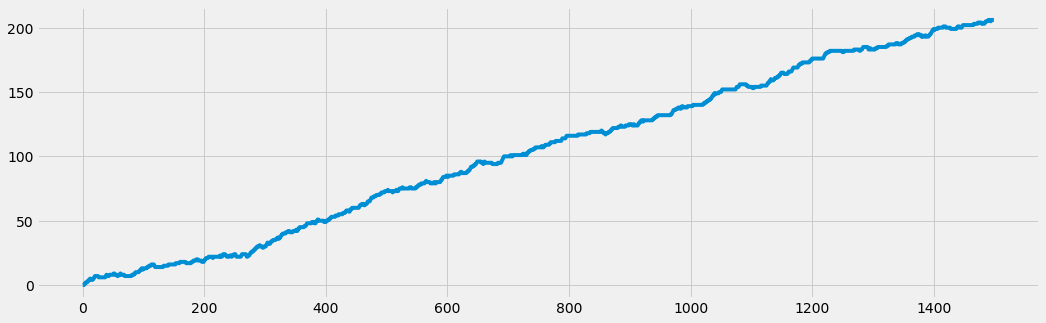

In [ ]:
plot_regret(y_optimal_list, y_hat_list)

Awww no. Looks like we're missing out on something! Let's be good scientists and look into that. To do so, we check our agents response at each context, for each arm (so we're going through the context twice)

### The Data

let's look at the agent's response in more detail:

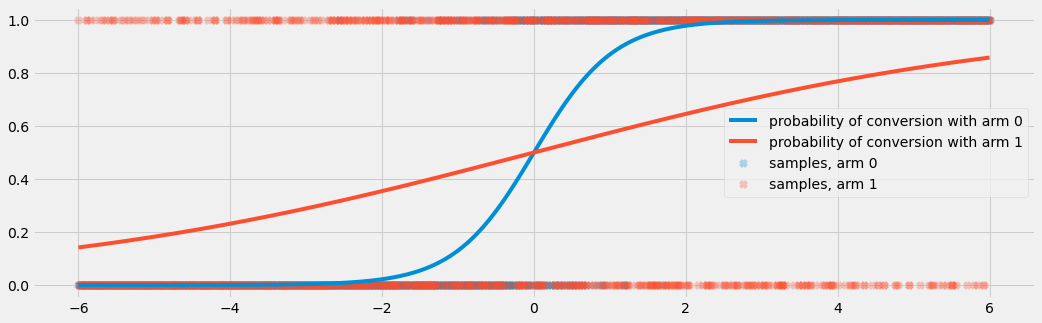

In [ ]:
for arm in [0,1]:
    y = []
    p1s = []
    p2s= []
    optimal_y = []
    for i in range(num_data):
        
        context = X_original[i]
        outcome, p1, p2 = contextual_categorical_bandit(context,arm,theta,noise)
        p1s.append(p1)
        p2s.append(p2)
        y.append(outcome)

        optimal_y.append(contextual_categorical_bandit(context, contextual_categorical_get_optimal_arm(context), theta, noise)[0])

    y = np.array(y).flatten()

    plt.scatter(X_original,y,alpha = 0.3, marker= 'x', label = f'samples, arm {arm}',)

    plt.plot(X_original,p2s, label = f'probability of conversion with arm {arm}')
plt.legend()


We can see that instead of having a clear winner, a choice that is almost always better as in the noncontextual case, this time, we are playing against two arms that have vastly different conversion probabilities depending on the context; arm1 is a better when the context is below 0, and arm0 is a lot more likley to convert when context is above the threshold.

In [ ]:
np.mean(y)

0.528

In [ ]:
np.mean(optimal_y)

0.63

# What is a contextual multi armed bandit situation?

The contextual multi armed bandit situation is similar to the one we encountered previously. We have a deicsion to make, and depending on that decision, we will get a reward. Not much new, so far. We want to know whether a dog on our website makes the user pay more for our product, think Humble Bundle.

As we did last time, we have to define a 'user' that will react to the arms we play. And as last time, we do this via a function called 'customer_reaction'. 

However, this time we have have some information about the user, formally known as context. In this case, it is the users age (1). We think that depending on how old the users are, they will react DIFFERENTLY to whether a dog is present or not. Here it is 'the older you are, the more you spending increases when you see a dog', meaning showing people a dog is the best decision above a certain age; below that age we're more likely to receive more money if we DO NOT SHOW A DOG.


This we'll model as a linear slope with 

$y = x \cdot m + t + \epsilon $

where 
$y$ is the target, i.e. how much the user spends

$x$ is the context, i.e. the users age

$m$ is a linear factor decided by whether a dog is present or not

$t$ is the onset; in our case that is 0

$\epsilon$ is gaussian noise, since we're still in a probabilistic setting


 (1) the users age is between -10 and 10 in this case. If you have a problem with this... redo this notebook with more sensible numbers. Have fun! 


As we can see, there are two general groups in the population, and they react diferent to the context; each one being more likley to convert in a different side of 0.
Let's have a look at the average response, if we choose at random and if we happen to choose the optimal arm.

When sampling at random, we see the following:

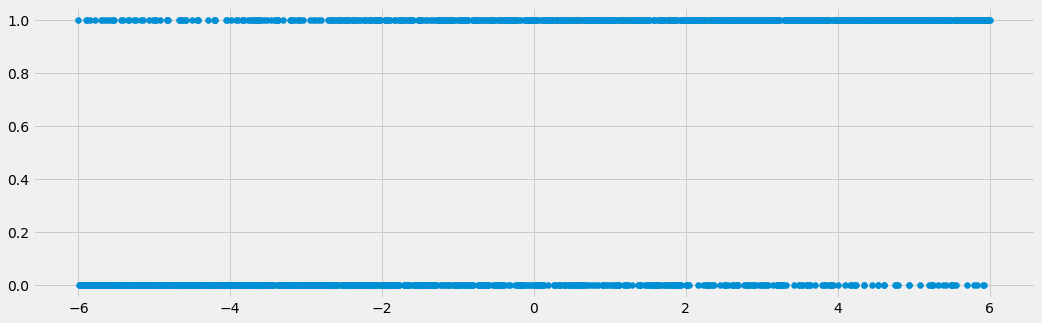

In [ ]:
plt.scatter(X_original, y)

In [ ]:
np.mean(y)

0.528

When we choose optimally, it look something like this:

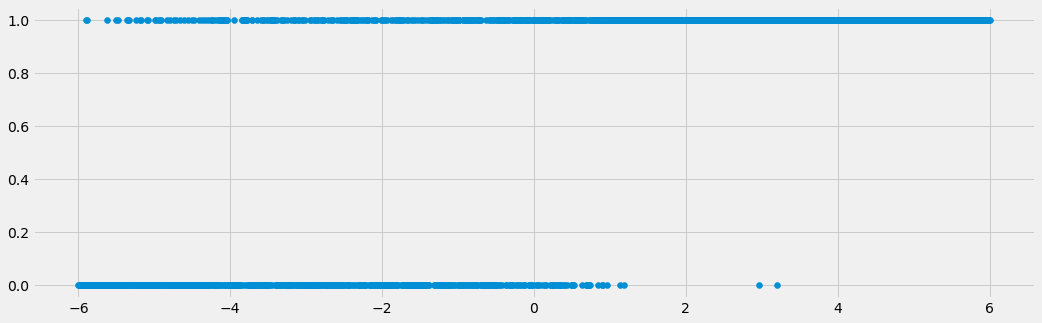

In [ ]:
plt.scatter(X_original, optimal_y)

In [ ]:
np.mean(optimal_y)

0.63

As we can see, the chance of generating a conversion with a random guess is practically 50%, whereas we can increase our conversion rate by ~10% if we manage to lways choose optimally (1). This effect largely stems from playing the arm that has a much higher chance of getting a reward when the context is larger than 0.


What we would like to do, and this is where we get to the fun part, is make our Thompson Sampler choose differently when considering the context.

(1) Like last time, remember - we are doing this in a probabilitic setting, so we are unlikely to generate round 

# Abstract solution
Last time, we put a large focus on the fact, that Thompson Sampling is a very simple approach to solving Multi Armed Bandit problems. A very big part of that simplicity came from the fact that the API we need (and that you are likely to find in packages designed with scalability in mind when it comes to TS - so you'll know what to look out for) is very simple. 

This still holds true for the contextual case. 
Let's compare the two.

In [ ]:
#hide
showcase_code('thompson_sampling/abstractions.py',class_name='AbstractSolver')

This is our Abstract Class that we used to define the solution to MABs, be it via AB testing, Epsilon Greedy or Thompson Samping. The API literally only gives us a way of choosing an arm and of updating the internal model. That's it!

In [ ]:
#hide
showcase_code('thompson_sampling/abstractions.py',class_name='AbstractContextualSolver')

This on the other hand (heh, arm) is the Contextual Solver abstraction. As we can see, it's basically the same; with the difference being that choose arm and update now accept another argument, the context that we want to optimize on. 
Note that we're also passing a type of model we want to use for the contextual prediction. This is because in theory, any model that can give us a predicitve distribution can be used for contextual TS. Whihc is super cool and we'll look into this a bit later, for now, we'll be using a very simple model, a linear one: logistic regression!

# Logistic Regression

But wait! 
We learned last time that in order to do thompson sampling, we need a distribution to draw from per arm we want to play; this distribution reflects the likelihood for the reward we're likely to receive. 
We also know that distributions usually don't use context; $ \mathcal{N}(\mu,\sigma)$ relies only on the mean and the standard deviation of the data we have observed - but in our case, $\mu$ changes rapidly with depending on whether a dog is present or not.
What do we do?



We become Bayesian, that's what we do. Honestly, that should always be the first thing you do when facing a problem.

![alt](https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/1200px-Bayes%27_Theorem_MMB_01.jpg)

More specifically, we will use a technique known as bayesian linear regression, which you can read about more about [here](https://en.wikipedia.org/wiki/Bayesian_linear_regression) and [here](https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7). Let's meet again after you checked those out. 



Hi! So now that you read that, you know how Bayesian Logistic Regression can be used to derive a distribution over categorical values depending on a linear model that we can train to give us everything we need. 
Let's do that. 


If you don't have the time, remember that last time we assigned a beta-binomial Posterior to each of the arms and sampled from that distribution to decide which arm we're going to play, bypassing the exploration vs exploitation dilemma.

Since we are focusing on Thompson Sampling rather than Bayesian Logistic Regression, we are not going to go into the model too deep. If you ever need it and you don't feel like looking it up, just... google it and you'll find implementations. 

I... did the same (although the linear regression is mine! Hah! The basic algorithm was taken from the fantastic https://gdmarmerola.github.io/ts-for-contextual-bandits/, which is a great resource on TS, too. I adapted it to suit our API design, since thats a major point in this notebook). 


No handles with labels found to put in legend.


<Figure size 1350x525 with 0 Axes>

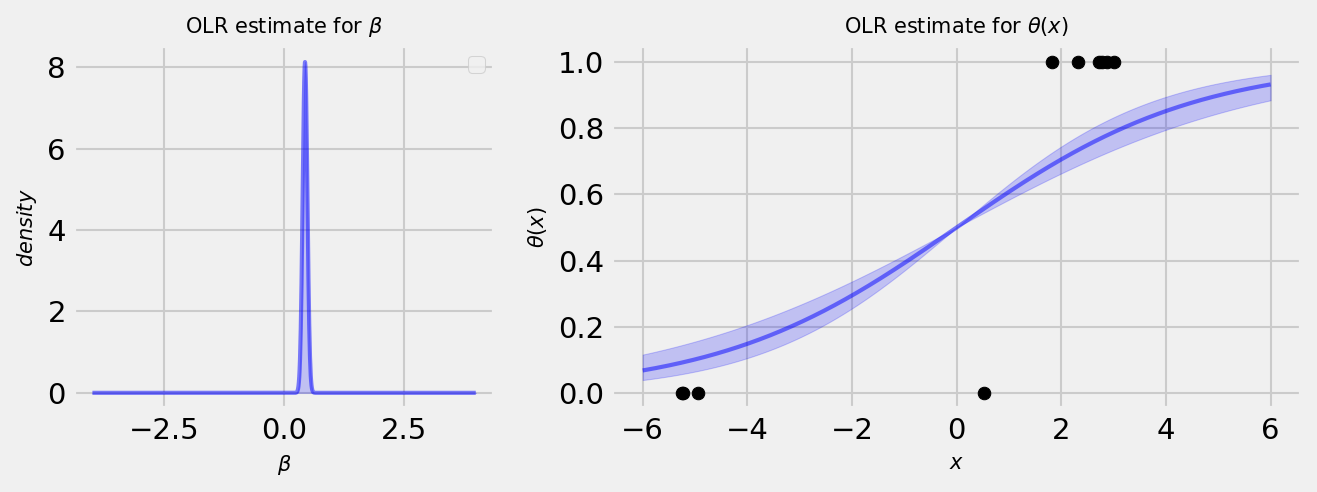

In [ ]:
import numpy as np
theta = [1.9, 0.3]
noise = 0.1


from thompson_sampling.helpers import plot_online_logreg
wee_x = np.random.uniform(-6,6,10)
wee_y = np.array([contextual_categorical_bandit(x,0, theta, noise)[0] for x in wee_x])




# OLR object
online_lr = OnlineLogisticRegression(1, .5, 1)
for i in range(len(wee_y)):
    online_lr.fit(wee_x[i].reshape(-1,1), wee_y[i].reshape(-1,1))
    
    
    
    
plot_online_logreg(online_lr, wee_x, wee_y)

 the first plot shows the distribution over the parameter $m$ from $y = \sigma(m \cdot x + t)$; the blue shade in the other plot shows the uncrtainty over the prediction. This is the distribution the Thompson Sampler samples from. This is important.

### Contextual Thompson Sampler

so now we've got all the pieces. We know roughly how our data looks like (obviously we wouldn't in the real case...), we have an abstract solution to the problem and we have a practical way of obtaining a distribution over predictions. 

Let's get to it!

As we can see, the thompsonsampler inherits from the abstract class - i.e. we're going to be dealing with an update() and a choose_arm() method. The update method trains our online logistic regression on a new data point, whereas the choose_arm method samples from the predictive distributions and returns the arm with the higher sample.

In [ ]:
showcase_code('thompson_sampling/solvers.py', class_name = 'LogisticThompsonSampler', end_string = True)

In [ ]:
lts = LogisticThompsonSampler(OnlineLogisticRegression, num_arms=2, num_context = 1)

Now, let's see the performance!

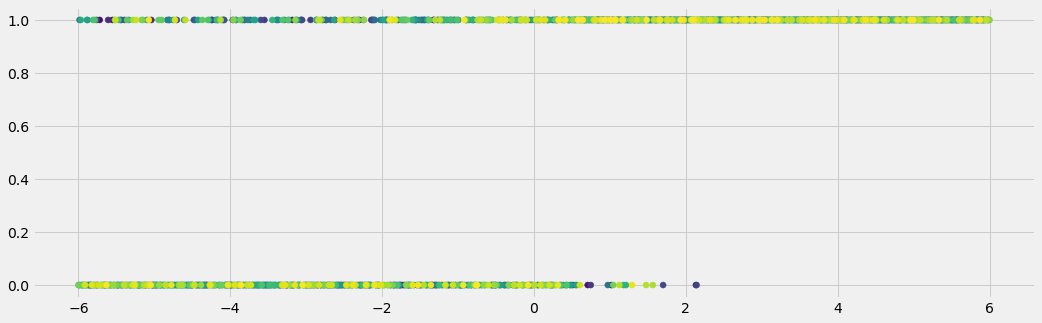

In [ ]:
y_hat_list = []
y_optimal_list = []
arms = []

for i in progress_bar(range(num_data)):
    context = X[i]
    

    arm = lts.choose_arm(context)
        
    arms.append(arm)

    y_hat = contextual_categorical_bandit(context,arm, theta,noise)[0]
    y_hat_list += [y_hat]

    lts.update(arm, context, y_hat)

    y_optimal = contextual_categorical_bandit(context, contextual_categorical_get_optimal_arm(context), theta, noise)[0]
    y_optimal_list.append(y_optimal)
plt.figure()
plt.scatter(X,np.array(y_hat_list),c=range(len(y_hat_list)))



In [ ]:
context

-0.9806537691794528

YASSSSS THIS LOOKS A LOT LIKE THE optimal choices we've seen above! We're getting confident, this looks good. 

Let's look a the regret:

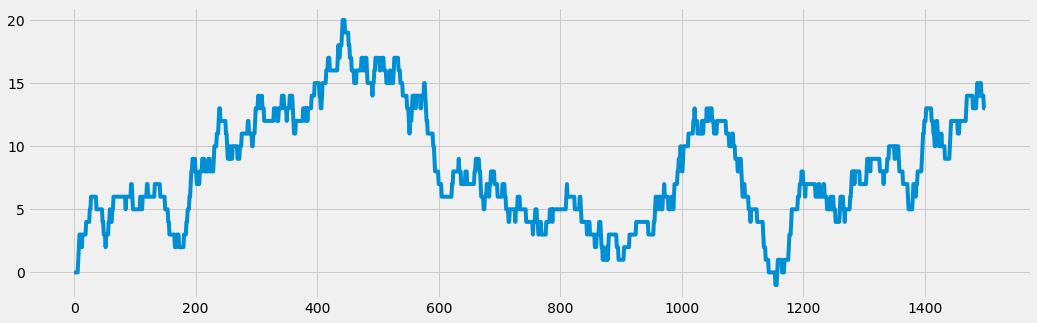

In [ ]:
plot_regret(y_optimal_list, y_hat_list)

UH YESSS THIS BABY LEARNED SOMETHING! again, due to the probabilistic nature of the reward, our regret will fluctuate a little bit inbetween sessions, but in genereal it seems to perform really well; our regret is fraction of the noncontextual solver; which makes sense. It didn't use the context.

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_abstractions.ipynb.
Converted 01_multi_armed_bandits.ipynb.
Converted 02_models.ipynb.
Converted 03_ensembles.ipynb.
Converted 04_solvers.ipynb.
Converted 10_adversarial_thompson_sampler.ipynb.
Converted 99_helpers.ipynb.
Converted contextual_bandits.ipynb.
Converted index.ipynb.
Converted noncontextual_bandits.ipynb.
Converted nonlinear_bandits.ipynb.
